Data shape: (2240, 24)
K=2: Inertia=54177.81, Silhouette=0.2422
K=3: Inertia=49416.69, Silhouette=0.1630
K=4: Inertia=46664.14, Silhouette=0.1704
K=5: Inertia=45129.89, Silhouette=0.1721
K=6: Inertia=42724.33, Silhouette=0.1084
K=7: Inertia=42177.02, Silhouette=0.1029
K=8: Inertia=41878.36, Silhouette=0.1075
K=9: Inertia=40350.75, Silhouette=0.0956
K=10: Inertia=39046.14, Silhouette=0.0983


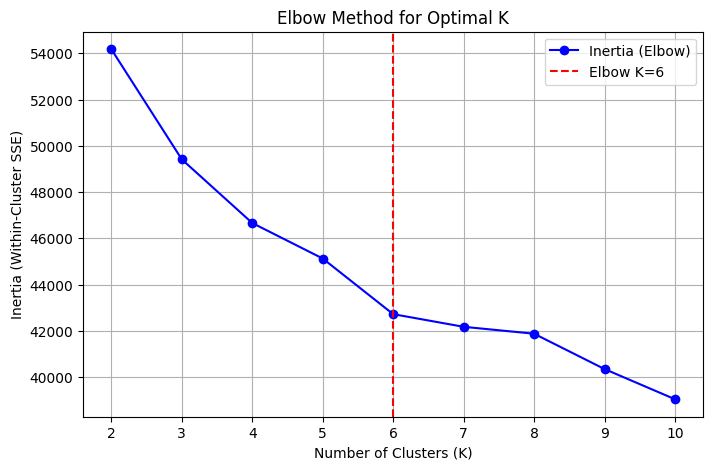

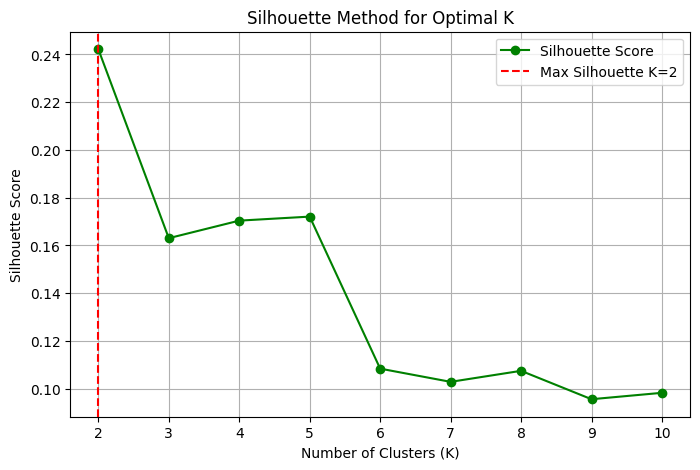


 Optimal K (Hybrid of Elbow=6 & Silhouette=2) → 4


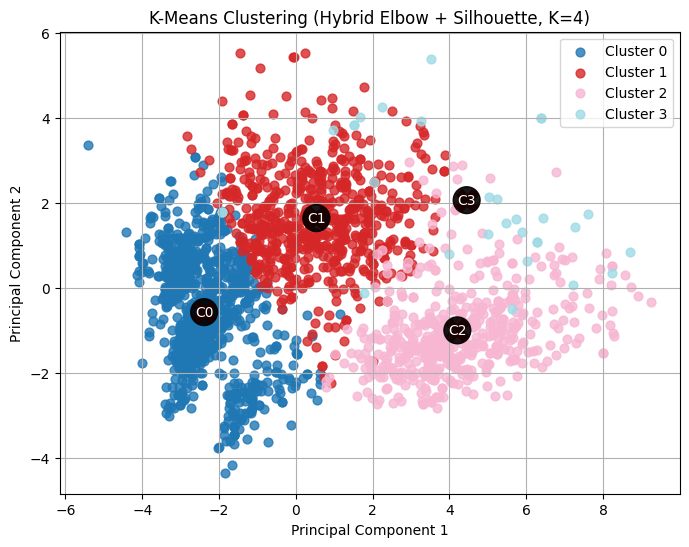


 KMeans cluster labels appended successfully to all_outputs.txt


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# LOAD PCA-TRANSFORMED DATA

df = pd.read_csv('cleaned_customer_data.csv')
X = df.values
print("Data shape:", X.shape)

# PERFORM K-MEANS FROM SCRATCH
class KMeansScratch:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        np.random.seed(random_state)

    def _initialize_centroids(self, X):
        n = len(X)
        centroids = [X[np.random.randint(0, n)]]
        for _ in range(1, self.n_clusters):
            dist_sq = np.min(np.linalg.norm(X[:, None] - np.array(centroids), axis=2)**2, axis=1)
            probs = dist_sq / dist_sq.sum()
            centroids.append(X[np.random.choice(range(n), p=probs)])
        return np.array(centroids)

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, None] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)
            new_centroids = np.array([
                X[self.labels == k].mean(axis=0) if np.any(self.labels == k) else self.centroids[k]
                for k in range(self.n_clusters)
            ])
            shift = np.linalg.norm(new_centroids - self.centroids)
            if shift < self.tol:
                break
            self.centroids = new_centroids
        self.inertia_ = np.sum((X - self.centroids[self.labels])**2)
        return self

#  SILHOUETTE SCORE
def silhouette_manual(X, labels):
    n = len(X)
    unique_labels = np.unique(labels)
    s_values = np.zeros(n)
    for i in range(n):
        same_cluster = X[labels == labels[i]]
        if len(same_cluster) > 1:
            a = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))
        else:
            a = 0
        b = np.inf
        for l in unique_labels:
            if l == labels[i]:
                continue
            other_cluster = X[labels == l]
            b = min(b, np.mean(np.linalg.norm(other_cluster - X[i], axis=1)))
        s_values[i] = (b - a) / max(a, b)
    return np.mean(s_values)

#  HYBRID ELBOW + SILHOUETTE METHOD
def choose_k_hybrid(X, k_min=2, k_max=10):
    Ks = list(range(k_min, k_max + 1))
    inertias, silhouettes = [], []

    for k in Ks:
        km = KMeansScratch(n_clusters=k)
        km.fit(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_manual(X, km.labels))
        print(f"K={k}: Inertia={km.inertia_:.2f}, Silhouette={silhouettes[-1]:.4f}")

    # ELBOW METHOD
    drops = np.diff(inertias)
    ratios = np.abs(drops[1:] / drops[:-1])
    best_k_elbow = Ks[np.argmin(ratios) + 1] if len(ratios) > 0 else Ks[0]

    plt.figure(figsize=(8,5))
    plt.plot(Ks, inertias, 'bo-', label='Inertia (Elbow)')
    plt.axvline(best_k_elbow, color='r', linestyle='--', label=f'Elbow K={best_k_elbow}')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia (Within-Cluster SSE)")
    plt.title("Elbow Method for Optimal K")
    plt.legend()
    plt.grid(True)
    plt.show()

    # SILHOUETTE METHOD
    best_k_sil = Ks[np.argmax(silhouettes)]
    plt.figure(figsize=(8,5))
    plt.plot(Ks, silhouettes, 'go-', label='Silhouette Score')
    plt.axvline(best_k_sil, color='r', linestyle='--', label=f'Max Silhouette K={best_k_sil}')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method for Optimal K")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- COMBINE BOTH ---
    best_k = int(round((best_k_elbow + best_k_sil) / 2))
    print(f"\n Optimal K (Hybrid of Elbow={best_k_elbow} & Silhouette={best_k_sil}) → {best_k}")
    return best_k, inertias, silhouettes, best_k_elbow, best_k_sil


# DETERMINE BEST K AND FIT FINAL MODEL

best_k, inertias, silhouettes, k_elbow, k_sil = choose_k_hybrid(X, k_min=2, k_max=10)
final_model = KMeansScratch(n_clusters=best_k).fit(X)
labels = final_model.labels
centroids = final_model.centroids


# PLOT FINAL CLUSTERS

plt.figure(figsize=(8,6))
colors = plt.cm.tab20(np.linspace(0, 1, best_k))

# PLOT CLUSTERS WITH LEGEND
for k in range(best_k):
    plt.scatter(X[labels==k,0], X[labels==k,1],
                s=40, alpha=0.8, color=colors[k], label=f"Cluster {k}")

# PLOT CENTROIDS
plt.scatter(centroids[:,0], centroids[:,1],
            c='red', s=250, marker='X')

# LABEL CENTROIDS
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], f"C{i}", color='white', ha='center', va='center',
             bbox=dict(facecolor='black', alpha=0.9, boxstyle='circle'))

plt.title(f"K-Means Clustering (Hybrid Elbow + Silhouette, K={best_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# APPEND CLUSTER LABELS TO all_outputs.txt

output_str = (
    f"KMeans_result  = "
    + ",".join(map(str, labels.tolist())) + "\n"
)
with open("all_outputs.txt", "a") as f:
    f.write(output_str)

print("\n KMeans cluster labels appended successfully to all_outputs.txt")



CUSTOMER SEGMENT PROFILES

 CLUSTER 0: 1074 customers (47.9%)
Income                   :   35511.18
Total_Spending           :     104.88
Recency                  :      49.56
Total_Children           :       1.24
NumWebPurchases          :       2.21
NumStorePurchases        :       3.27
NumCatalogPurchases      :       0.59
MntWines                 :      46.18
MntMeatProducts          :      24.93
Age                      :      53.70

 CLUSTER 1: 639 customers (28.5%)
Income                   :   59889.04
Total_Spending           :     797.05
Recency                  :      48.25
Total_Children           :       1.17
NumWebPurchases          :       6.60
NumStorePurchases        :       8.03
NumCatalogPurchases      :       3.40
MntWines                 :     467.18
MntMeatProducts          :     157.47
Age                      :      59.99

 CLUSTER 2: 497 customers (22.2%)
Income                   :   77411.09
Total_Spending           :    1400.01
Recency                  :      

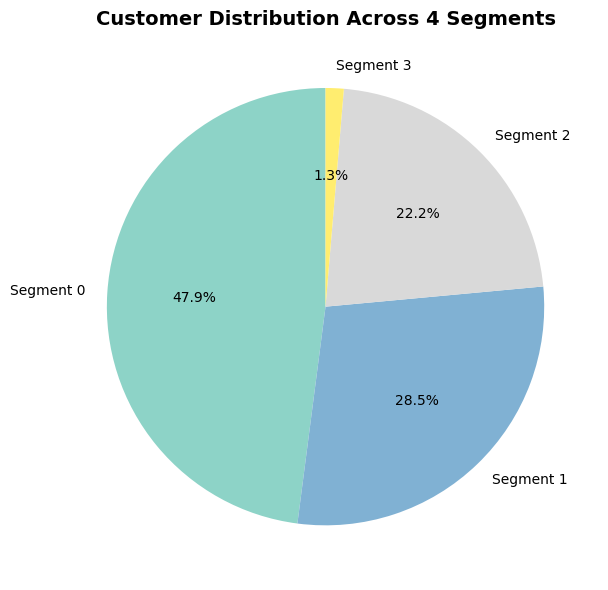

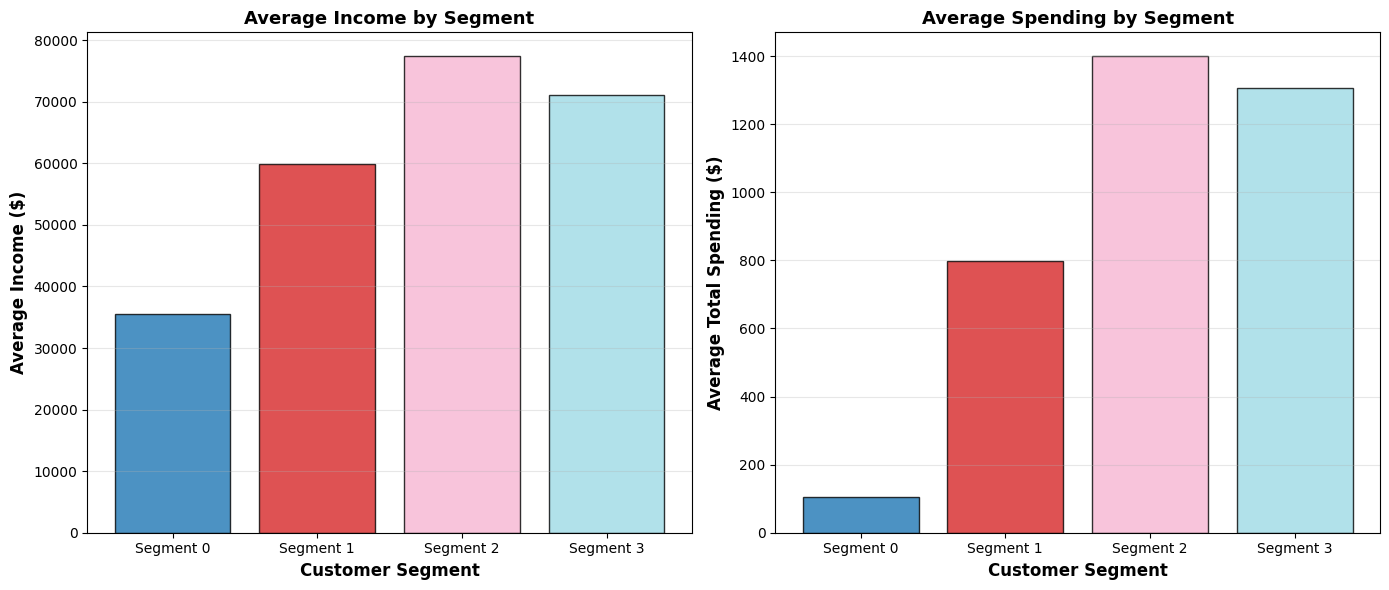

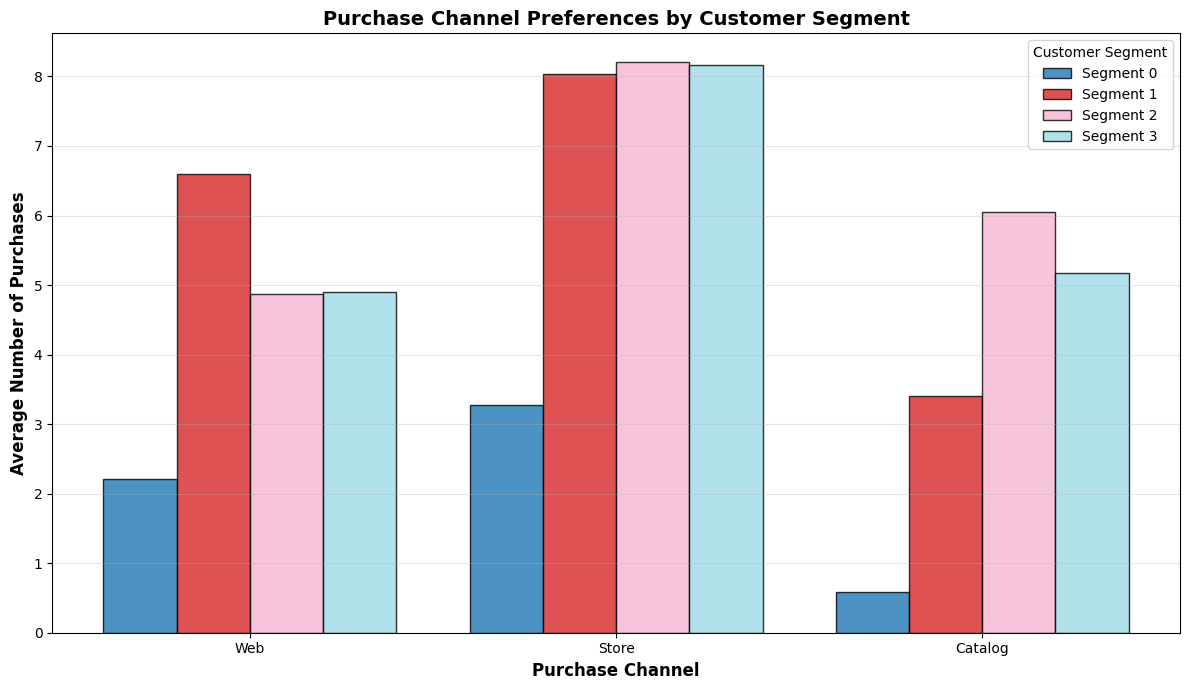

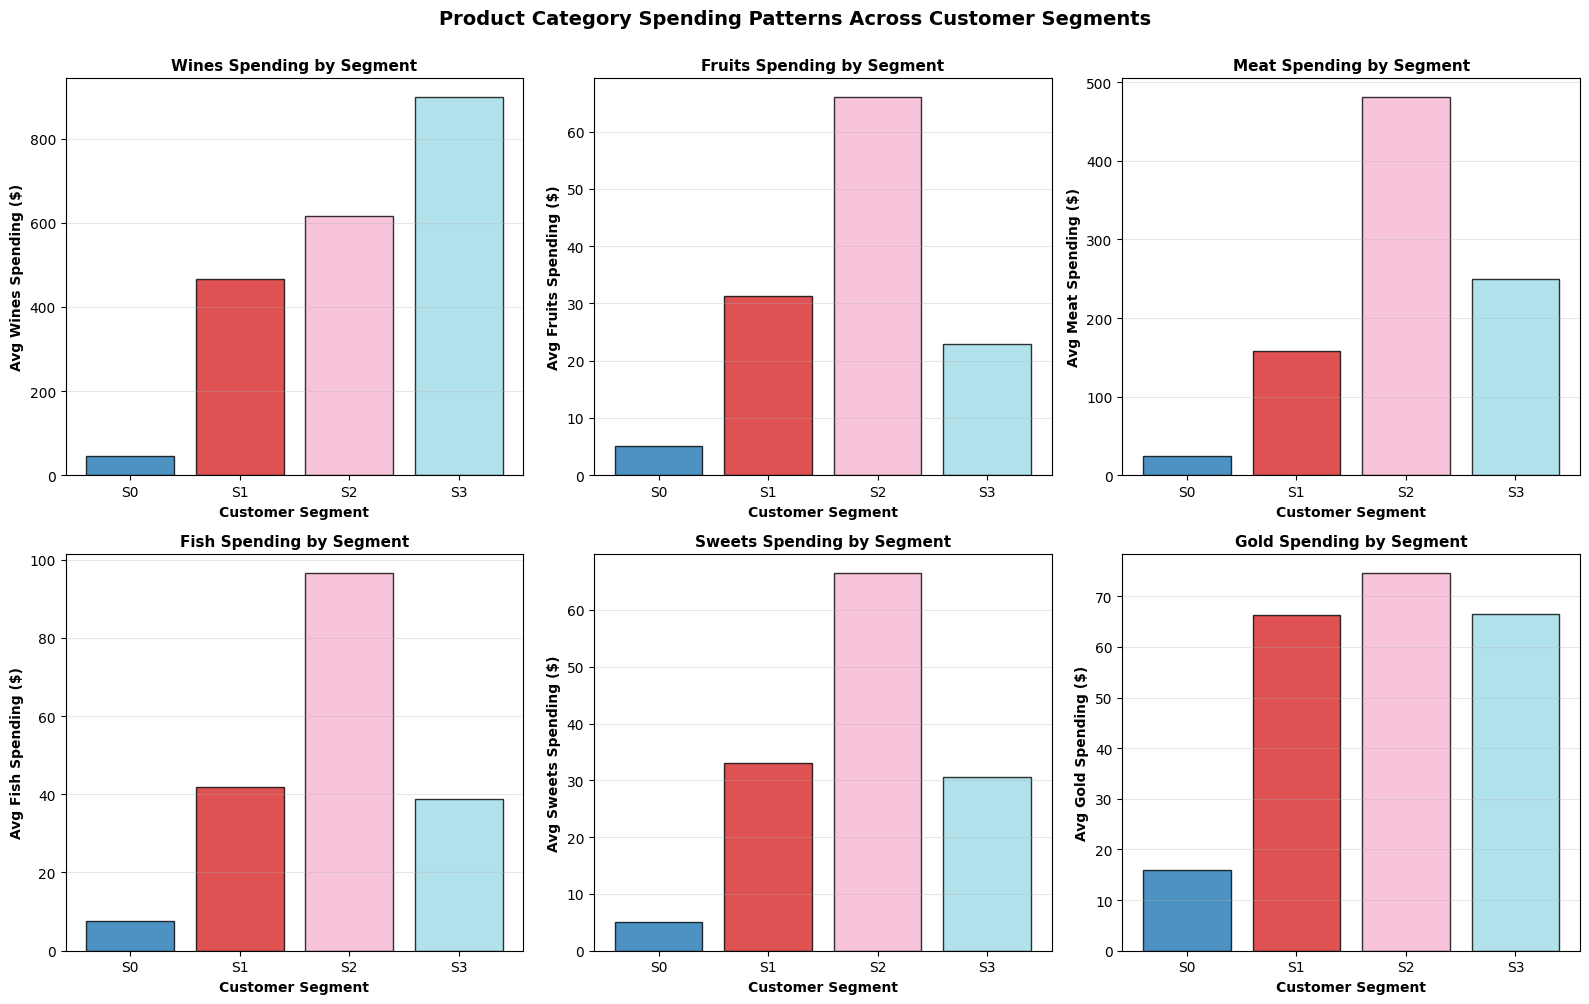

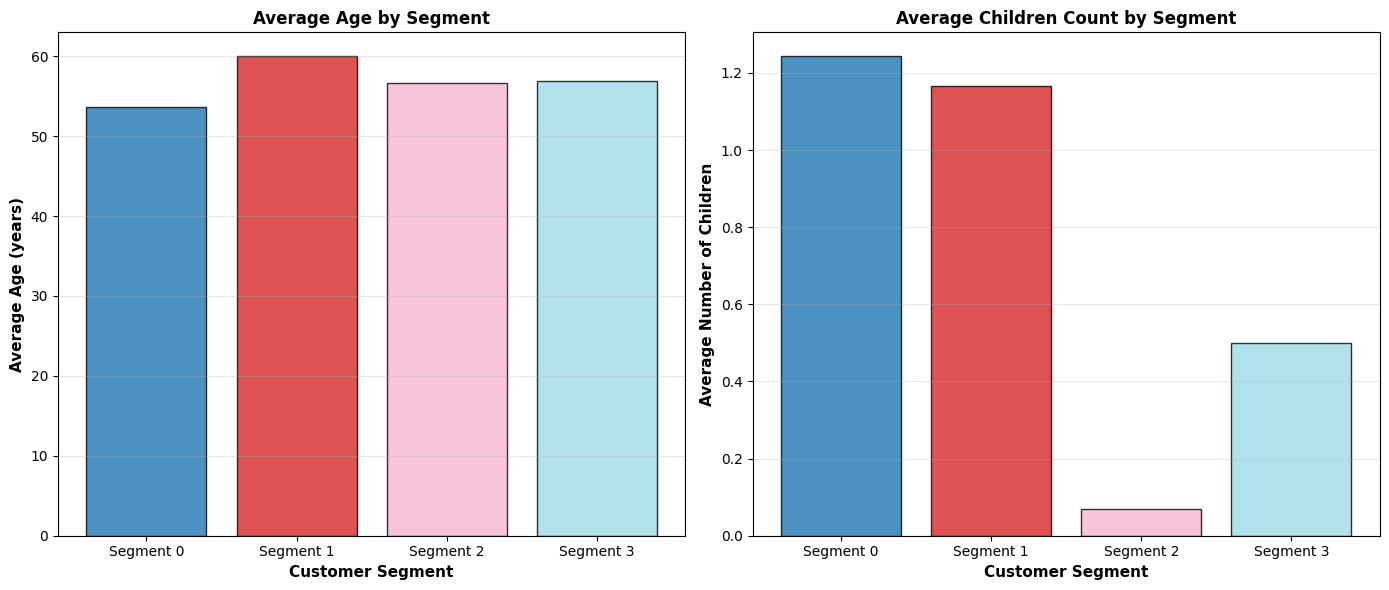

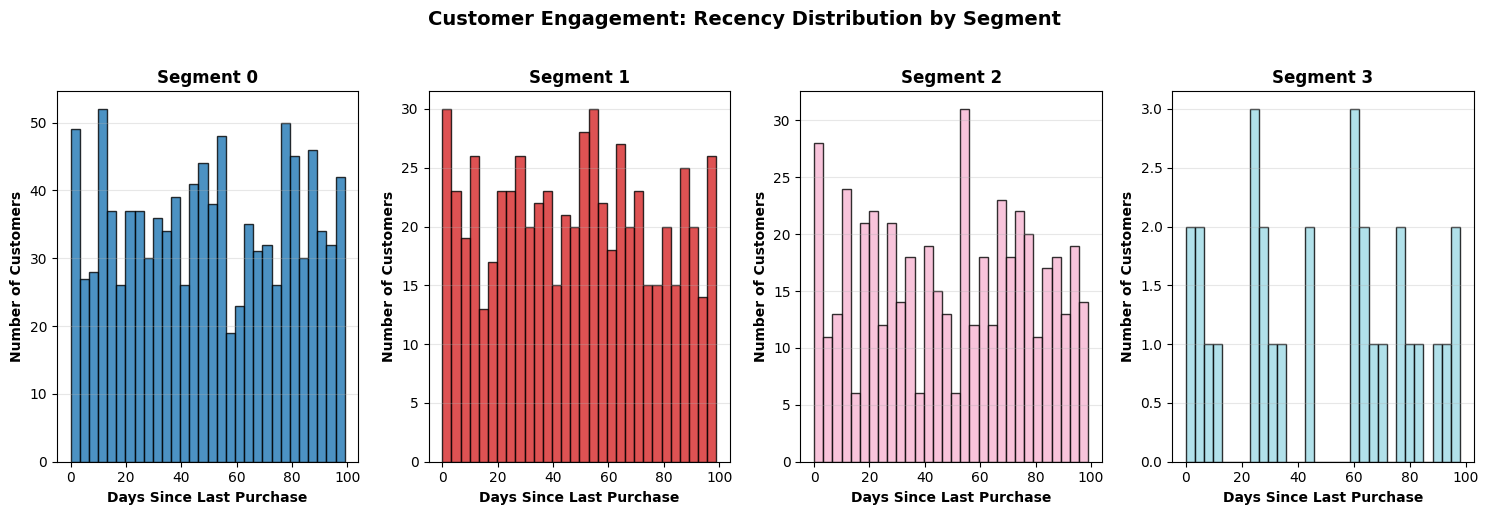

CUSTOMER SEGMENTATION PERFORMED SUCCESSFULLY
Total customers segmented: 2240
Number of segments created: 4


In [2]:
# Load original data for interpretation
df_original = pd.read_csv('cdata.csv')

# Add cluster labels to original data
df_original['Cluster'] = labels

# Cluster Profiling - Understanding each segment

print("CUSTOMER SEGMENT PROFILES")


# Select key features for profiling
profile_features = ['Income', 'Total_Spending', 'Recency', 'Total_Children',
                    'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases',
                    'MntWines', 'MntMeatProducts']

# Calculate Age

df_original['Age'] = 2025 - df_original['Year_Birth']
profile_features.append('Age')

# Profile each cluster
for cluster_id in range(best_k):
    cluster_data = df_original[df_original['Cluster'] == cluster_id]
    print("\n",f"CLUSTER {cluster_id}: {len(cluster_data)} customers ({len(cluster_data)/len(df_original)*100:.1f}%)")
    available_features = [f for f in profile_features if f in df_original.columns]
    for feature in available_features:
        mean_val = cluster_data[feature].mean()
        print(f"{feature:25s}: {mean_val:10.2f}")

# VISUALIZATION 1: Cluster Sizes
plt.figure(figsize=(10, 6))
cluster_counts = pd.Series(labels).value_counts().sort_index()
colors_pie = plt.cm.Set3(np.linspace(0, 1, best_k))
plt.pie(cluster_counts, labels=[f'Segment {i}' for i in range(best_k)],
        autopct='%1.1f%%', colors=colors_pie, startangle=90)
plt.title(f'Customer Distribution Across {best_k} Segments', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# VISUALIZATION 2: Income vs Total Spending by Cluster (BAR PLOT)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Average Income by Segment
income_means = [df_original[df_original['Cluster'] == k]['Income'].mean() for k in range(best_k)]
ax1.bar(range(best_k), income_means, color=colors[:best_k], alpha=0.8, edgecolor='black')
ax1.set_xlabel('Customer Segment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Income ($)', fontsize=12, fontweight='bold')
ax1.set_title('Average Income by Segment', fontsize=13, fontweight='bold')
ax1.set_xticks(range(best_k))
ax1.set_xticklabels([f'Segment {k}' for k in range(best_k)])
ax1.grid(True, alpha=0.3, axis='y')

# Average Spending by Segment
spending_means = [df_original[df_original['Cluster'] == k]['Total_Spending'].mean() for k in range(best_k)]
ax2.bar(range(best_k), spending_means, color=colors[:best_k], alpha=0.8, edgecolor='black')
ax2.set_xlabel('Customer Segment', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Total Spending ($)', fontsize=12, fontweight='bold')
ax2.set_title('Average Spending by Segment', fontsize=13, fontweight='bold')
ax2.set_xticks(range(best_k))
ax2.set_xticklabels([f'Segment {k}' for k in range(best_k)])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# VISUALIZATION 3: Purchase Channel Preferences
purchase_channels = ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']
channel_means = []

for k in range(best_k):
    cluster_data = df_original[df_original['Cluster'] == k]
    means = [cluster_data[channel].mean() for channel in purchase_channels]
    channel_means.append(means)

fig, ax = plt.subplots(figsize=(12, 7))
x_pos = np.arange(len(purchase_channels))
width = 0.8 / best_k

for k in range(best_k):
    ax.bar(x_pos + k * width, channel_means[k], width,
           label=f'Segment {k}', color=colors[k], alpha=0.8, edgecolor='black')

ax.set_xlabel('Purchase Channel', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Number of Purchases', fontsize=12, fontweight='bold')
ax.set_title('Purchase Channel Preferences by Customer Segment', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width * (best_k - 1) / 2)
ax.set_xticklabels(['Web', 'Store', 'Catalog'])
ax.legend(title='Customer Segment')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# VISUALIZATION 4: Product Category Spending (BAR PLOTS)
product_categories = ['MntWines', 'MntFruits', 'MntMeatProducts',
                      'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
category_labels = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (category, label) in enumerate(zip(product_categories, category_labels)):
    category_means = [df_original[df_original['Cluster'] == k][category].mean() for k in range(best_k)]

    axes[idx].bar(range(best_k), category_means, color=colors[:best_k],
                  alpha=0.8, edgecolor='black')

    axes[idx].set_xlabel('Customer Segment', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel(f'Avg {label} Spending ($)', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{label} Spending by Segment', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(range(best_k))
    axes[idx].set_xticklabels([f'S{k}' for k in range(best_k)])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Product Category Spending Patterns Across Customer Segments',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# VISUALIZATION 5: Customer Demographics (BAR PLOTS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Average Age by Segment
if 'Age' in df_original.columns:
    age_means = [df_original[df_original['Cluster'] == k]['Age'].mean() for k in range(best_k)]
    ax1.bar(range(best_k), age_means, color=colors[:best_k], alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Customer Segment', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Average Age (years)', fontsize=11, fontweight='bold')
    ax1.set_title('Average Age by Segment', fontsize=12, fontweight='bold')
    ax1.set_xticks(range(best_k))
    ax1.set_xticklabels([f'Segment {k}' for k in range(best_k)])
    ax1.grid(True, alpha=0.3, axis='y')

# Average Children Count
children_means = [df_original[df_original['Cluster'] == k]['Total_Children'].mean() for k in range(best_k)]
ax2.bar(range(best_k), children_means, color=colors[:best_k], alpha=0.8, edgecolor='black')
ax2.set_xlabel('Customer Segment', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Number of Children', fontsize=11, fontweight='bold')
ax2.set_title('Average Children Count by Segment', fontsize=12, fontweight='bold')
ax2.set_xticks(range(best_k))
ax2.set_xticklabels([f'Segment {k}' for k in range(best_k)])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# VISUALIZATION 6: Recency Analysis - Histogram
fig, axes = plt.subplots(1, best_k, figsize=(15, 5))

for k in range(best_k):
    cluster_data = df_original[df_original['Cluster'] == k]['Recency']
    axes[k].hist(cluster_data, bins=30, color=colors[k], alpha=0.8, edgecolor='black')
    axes[k].set_xlabel('Days Since Last Purchase', fontsize=10, fontweight='bold')
    axes[k].set_ylabel('Number of Customers', fontsize=10, fontweight='bold')
    axes[k].set_title(f'Segment {k}', fontsize=12, fontweight='bold')
    axes[k].grid(True, alpha=0.3, axis='y')

fig.suptitle('Customer Engagement: Recency Distribution by Segment',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("CUSTOMER SEGMENTATION PERFORMED SUCCESSFULLY")
print(f"Total customers segmented: {len(df_original)}")
print(f"Number of segments created: {best_k}")
